In [1]:
MOVIE_PATH = "data/Oblivion.mp4"
DO_FRAMES = 2000  # -1 means whole movie
SKIP_FRAMES = 0

In [ ]:
import cv2
import math
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import face_recognition
import tensorflow as tf
from facenet.src import facenet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.externals import joblib
%matplotlib inline

In [ ]:
face_cascade = cv2.CascadeClassifier('data/lbpcascade_frontalface_improved.xml')

In [2]:
capture = cv2.VideoCapture(MOVIE_PATH)

In [3]:
assert capture.isOpened()

True

In [4]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
if int(major_ver)  < 3 :
    fps = capture.get(cv2.cv.CV_CAP_PROP_FPS)
else :
    fps = capture.get(cv2.CAP_PROP_FPS)

Frames per second using video.get(cv2.CAP_PROP_FPS) : 23.976023976023978


In [5]:
def detect_faces(frame):
    face_locations = []
    faces = []
    faces = face_recognition.face_locations(frame)
    if faces:
        for face in faces:
            face_locations.append(face)
    return face_locations

def detect_faces_cascade(frame):
    face_locations = []
    faces = []
    gray_img = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=3)
    if len(faces) > 0:
        for face in faces:
            face_locations.append([face[1], face[0]+face[2], face[1]+face[3], face[0]])
    return face_locations

In [6]:
knn1 = joblib.load('db/knn_embedings1')
knn2 = joblib.load('db/knn_embedings2')

In [7]:
face_locations = None
sec = 0
faces = []
ret, frame = capture.read()
while ret:
    if DO_FRAMES != -1 and len(faces) > DO_FRAMES:
        break
    face_locations = detect_faces(frame)
    if face_locations:
        faces.append((frame,face_locations))
    else:
        faces.append(None)
    for frame in range(SKIP_FRAMES+1):
        ret, frame = capture.read()

In [8]:
frames_actors = []

In [9]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        facenet.load_model("data/20170512-110547/")
        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        image_size = 160
        embedding_size = embeddings.get_shape()[1]
        for face in faces:
            if face:
                frame = face[0]
                locations = face[1]
                gray_img = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
                encodings = face_recognition.face_encodings(gray_img, known_face_locations=locations)
                current_frame = [] 
                for encoding in encodings:
                    real_encodings = np.reshape(list(encoding), (1, -1))
                    res_dict = {'knn': knn2.predict(real_encodings),
                                'knn_prob': knn2.predict_proba(real_encodings).max()}
                    current_frame.append(res_dict)
                
                face_landmarks_list = face_recognition.face_landmarks(frame, face_locations=locations)
                if face_landmarks_list:
                    for face_landmark in face_landmarks_list:
                        desiredLeftEye = (0.35, 0.35)
                        desiredFaceWidth = 160
                        l_eye = np.array(face_landmark['left_eye']).reshape(6,2).mean(axis=0).astype(int)
                        r_eye = np.array(face_landmark['right_eye']).reshape(6,2).mean(axis=0).astype(int)
                        dY = r_eye[1] - l_eye[1]
                        dX = r_eye[0] - l_eye[0]
                        angle = np.degrees(np.arctan2(dY, dX))
                        desiredRightEyeX = 1.0 - desiredLeftEye[0]
                        dist = np.sqrt((dX ** 2) + (dY ** 2))
                        desiredDist = (desiredRightEyeX - desiredLeftEye[0])
                        desiredDist *= desiredFaceWidth
                        scale = desiredDist / dist
                        # compute center (x, y)-coordinates (i.e., the median point)
                        # between the two eyes in the input image
                        eyesCenter = ((l_eye[0] + r_eye[0]) // 2, (l_eye[1] + r_eye[1]) // 2)

                        # grab the rotation matrix for rotating and scaling the face
                        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

                        # update the translation component of the matrix
                        tX = desiredFaceWidth * 0.5
                        tY = desiredFaceWidth * desiredLeftEye[1]
                        M[0, 2] += (tX - eyesCenter[0])
                        M[1, 2] += (tY - eyesCenter[1])
                        # apply the affine transformation
                        (w, h) = (desiredFaceWidth, desiredFaceWidth)
                        output = cv2.warpAffine(frame, M, (w, h), flags=cv2.INTER_CUBIC)

                        # Run forward pass to calculate embeddings
                        feed_dict = { images_placeholder:[output], phase_train_placeholder:False }
                        emb_array = sess.run(embeddings, feed_dict=feed_dict)
                        for emb in emb_array:
                            real_encodings = np.reshape(list(emb), (1, -1))
                            res_dict = {'knn':knn1.predict(real_encodings),
                                        'knn_prob': knn1.predict_proba(real_encodings).max()}
                            current_frame.append(res_dict)
                frames_actors.append(current_frame)
            else:
                frames_actors.append(None)

Model directory: data/20170512-110547/
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from data/20170512-110547/model-20170512-110547.ckpt-250000


In [11]:
clean_frames = []
replace_actors = {}
actors_in_frames = {}

In [12]:
frame_count = 0
for frame in frames_actors:
    if frame is None:
        clean_frames.append(0)
        continue
    detected_actors = []
    for actor in frame:
        if 'knn_prob' in actor:
            if actor['knn_prob'] >= 0.5:
                if actor['knn'][0] not in replace_actors:
                    replace_actors[actor['knn'][0]] = 1
                    actors_in_frames[actor['knn'][0]] = [frame_count]
                else:
                    replace_actors[actor['knn'][0]] += 1
                    actors_in_frames[actor['knn'][0]].append(frame_count)
                detected_actors.append(actor['knn'][0])
            else:
                detected_actors.append(0)
    frame_count += 1
    clean_frames.append(detected_actors)

In [45]:
clean_actors = {}
offset = 0
for actor in actors_in_frames.keys():
    if len(actors_in_frames[actor]) < 10:
        continue
    play = np.zeros(2000)
    for frame in actors_in_frames[actor]:
        play[frame] = 0.6 + offset
    clean_actors[actor] = play
    offset += 0.1

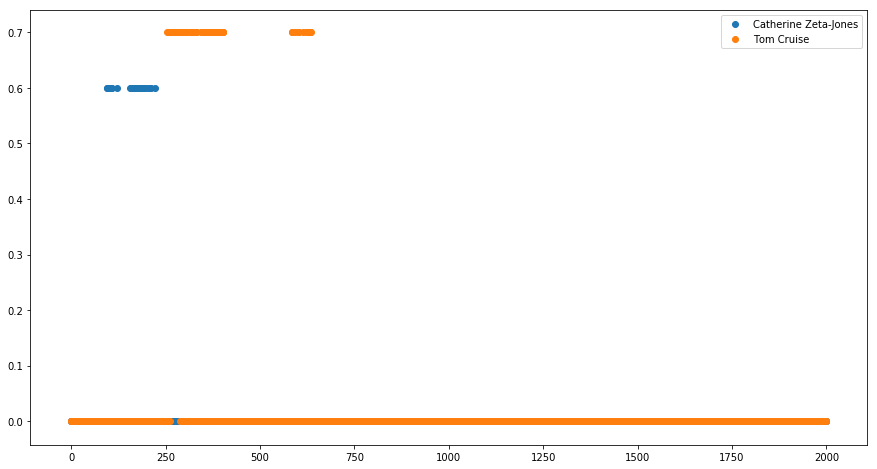

In [47]:
lines = []
plt.subplots(1,1, figsize=(15, 8))
for actor in clean_actors.keys():
    line = plt.scatter(range(len(clean_actors[actor])), clean_actors[actor])
    lines.append(line)

plt.legend(lines,clean_actors.keys())

In [51]:
for actor in replace_actors.keys():
    if replace_actors[actor] > 10:
        print(actor, replace_actors[actor]/fps,'s')

Catherine Zeta-Jones 1.626625 s
Tom Cruise 3.920583333333333 s
